## Don't overfit
This notebook is used to fit data for the don't overfit II competition on Kaggle
Make sure to download the data to run it<br>
Big thanks to Andrew Lukyanenko for his valuable kernel

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import clear_output, HTML

import os
import logging
data_path = "../dataset/dont_over_fit"
print(os.listdir(data_path))

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

import eli5
import shap
from eli5.sklearn import PermutationImportance
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.offline as py
from zipfile import ZipFile
py.init_notebook_mode(connected=True)

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'test.csv.zip']


In [3]:
train_dataset = pd.read_csv(data_path + "/train.csv")
train_dataset.shape

(250, 302)

In [4]:
train_dataset.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [5]:
ZipFile(data_path + "/test.csv.zip").extractall(data_path)
test = pd.read_csv(data_path+ "/test.csv")
print(test.shape)
test.head()

(19750, 301)


,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


In [6]:
sum(train_dataset.isna().sum())

0

In [7]:
train_dataset['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [8]:
print('std ', np.std(np.mean(train_dataset.iloc[:,2:], axis=0)))
print('min ', np.min(np.mean(train_dataset.iloc[:,2:], axis=0)))
print('max ', np.max(np.mean(train_dataset.iloc[:,2:], axis=0)))

std  0.06351479140973558
min  -0.200064
max  0.18962799999999988


In [9]:
train_data, val_data = train_test_split(train_dataset, train_size=0.8, random_state=123)

/home/yas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [10]:
train_dataset["target"].value_counts()/len(train_data)

1.0    0.80
0.0    0.45
Name: target, dtype: float64

In [11]:
class_weight = {1.0: 0.64, 0.0:0.36}

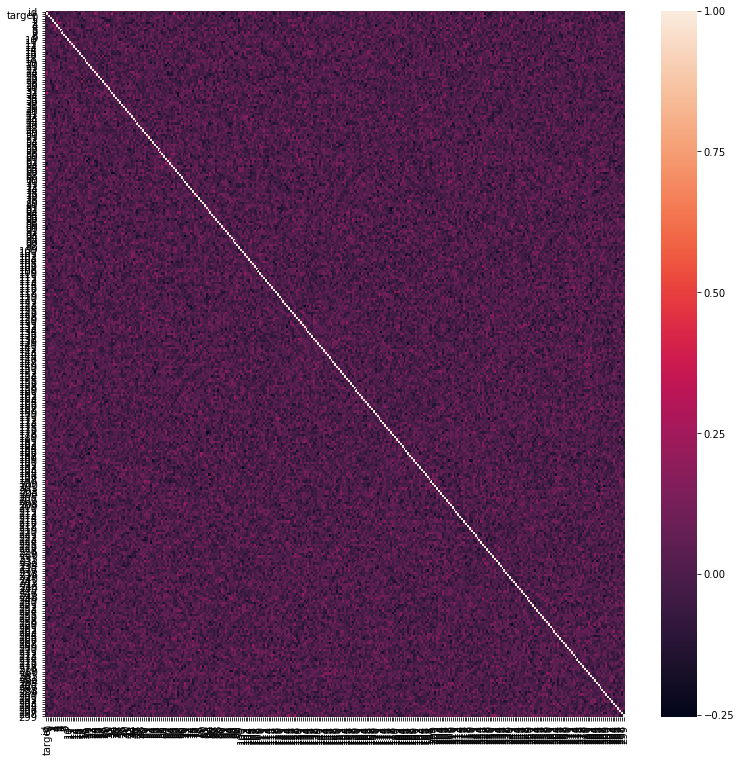

In [12]:
figure(figsize=(13, 13))
corr = train_data.corr()
sns.heatmap(corr, xticklabels = train_data.columns, yticklabels= train_data.columns)

In [13]:
cor = train_data.corr().abs().unstack().sort_values(kind='quicksort').reset_index()

In [14]:
cor[cor['level_0'] != cor['level_1']].tail(10)

,level_0,level_1,0
90892,122,270,0.257027
90893,270,122,0.257027
90894,131,155,0.268666
90895,155,131,0.268666
90896,61,63,0.292745
90897,63,61,0.292745
90898,target,65,0.336960
90899,65,target,0.336960
90900,target,33,0.354839
90901,33,target,0.354839


In [15]:
train_label = train_data['target']
train_data = train_data.drop(['id','target'], axis=1)
val_label = val_data['target']
val_data = val_data.drop(['id','target'], axis=1)

In [16]:
folds = StratifiedKFold(n_splits = 20, shuffle = True, random_state= 10)
repeatedfolds = RepeatedStratifiedKFold(n_splits = 20, n_repeats = 20)

In [17]:

sd_sc = StandardScaler()
train_data = sd_sc.fit_transform(train_data)
val_data = sd_sc.transform(val_data)

In [18]:
val_label = val_label.values
train_label = train_label.values

In [19]:
def train_model(train, label, test, params, folds=folds, model_type='sklearn', model= None, averaging='usual'):
    oof = np.zeros(len(train))
    prediction = np.zeros(len(test))
    scores = []
    for fold_n, (train_idx, test_idx) in enumerate(folds.split(train, label)):
        x_train, x_val = train[train_idx], train[test_idx]
        y_train, y_val = label[train_idx], label[test_idx]
        if model_type == 'cat':
            cat = CatBoostClassifier(iterations=2000, eval_metric='AUC', **params)
            cat.fit(x_train, y_train, cat_features=[], eval_set=(x_val, y_val), use_best_model=True)
            y_val_pred = cat.predict(x_val)
            y_pred = cat.predict(test)
        if model_type == 'xgb':
            dtrain = xgb.DMatrix(x_train, label= y_train, feature_names=x_train.columns)
            dval = xgb.DMatrix(x_val, label = y_val, feature_names=x_train.columns)
            dtest = xgb.DMatrix(test, feature_names=x_train.columns)
            evallist = [(dval, 'test'), (dtrain, 'train')]
            model = xgb.train(params, dtrain, num_round=2000, evals=evallist, early_stopping_rounds=200)
            y_val_pred = model.predict(xgb.DMatrix(x_val, feature_names=x_train.columns),
                                       ntree_limit = model.best_ntree_limit)
            y_pred = model.predict(dtest, ntree_limit = model.best_ntree_limit)
        if model_type == 'lgb':
            dtrain = lgb.Dataset(x_train, y_train)
            dval = lgb.Dataset(x_val, y_val)
            model = lgb.train(params, dtrain,num_boost_round=2000, valid_sets=[dtrain, dval], early_stopping_rounds=200)
            y_val_pred = model.predict(dval)
            y_pred = model.predict(test, num_iteration= model.best_iteration_)
        if model_type == 'sklearn':
            model.fit(x_train, y_train)
            y_val_pred = model.predict(x_val).reshape(-1,)
            y_pred = model.predict_proba(test)[:,1]
        scores.append(roc_auc_score(y_val, y_val_pred))
        oof[test_idx] = y_val_pred.reshape(-1,)
        if averaging == 'usual':
            prediction += y_pred
        else:
            prediction += pd.Series(y_pred).rank().values()
    prediction /= fold_n
    clear_output()
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    return oof, scores, prediction

In [20]:
model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof, score, predition = train_model(train_data, train_label, val_data, params=None, model= model)

CV mean score: 0.7101, std: 0.1199.


In [21]:
parameters = {"learning_rate":0.02, "depth":5, "early_stopping_rounds":20}
oof2, score2, predition2 = train_model(train_data, train_label, val_data, parameters, model_type='cat')

CV mean score: 0.5554, std: 0.0932.


In [22]:
parameters = {"learning_rate":0.1, "depth":5, "early_stopping_rounds":20, "l2_leaf_reg":10}
model = CatBoostClassifier(iterations=200, eval_metric='AUC', **parameters)
model.fit(train_data, train_label, cat_features=[])

0:	total: 18.1ms	remaining: 3.6s
1:	total: 30.9ms	remaining: 3.06s
2:	total: 43.4ms	remaining: 2.85s
3:	total: 58.9ms	remaining: 2.89s
4:	total: 73.5ms	remaining: 2.87s
5:	total: 86.3ms	remaining: 2.79s
6:	total: 99.1ms	remaining: 2.73s
7:	total: 115ms	remaining: 2.76s
8:	total: 130ms	remaining: 2.77s
9:	total: 147ms	remaining: 2.79s
10:	total: 161ms	remaining: 2.76s
11:	total: 173ms	remaining: 2.71s
12:	total: 186ms	remaining: 2.68s
13:	total: 203ms	remaining: 2.69s
14:	total: 218ms	remaining: 2.68s
15:	total: 233ms	remaining: 2.68s
16:	total: 251ms	remaining: 2.7s
17:	total: 264ms	remaining: 2.67s
18:	total: 277ms	remaining: 2.63s
19:	total: 289ms	remaining: 2.6s
20:	total: 301ms	remaining: 2.56s
21:	total: 313ms	remaining: 2.53s
22:	total: 329ms	remaining: 2.53s
23:	total: 354ms	remaining: 2.59s
24:	total: 368ms	remaining: 2.57s
25:	total: 380ms	remaining: 2.54s
26:	total: 392ms	remaining: 2.51s
27:	total: 405ms	remaining: 2.48s
28:	total: 420ms	remaining: 2.48s
29:	total: 435ms	rem

In [23]:
model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof3, score3, predition3 = train_model(train_data, train_label, val_data, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.7025, std: 0.1352.


In [24]:
oof4, score4, predition4 = train_model(train_data, train_label, test.iloc[:,1:], params=None, model= model, folds=repeatedfolds)

CV mean score: 0.7075, std: 0.1430.


In [25]:
submission = pd.DataFrame({'id':test.id, 'target':predition4})
submission.to_csv('submission1.csv', index = False)

In [26]:
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    """this function is used with Kaggle kernel to download the submission file"""
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
#create_download_link(filename='submission1.csv')

In [27]:
eli5.show_weights(model, top=50)

Weight?,Feature
+0.508,x33
+0.486,x65
+0.193,x199
+0.113,x24
+0.082,x226
+0.046,x168
+0.035,x272
+0.026,x289
+0.011,x162
+0.009,x107


In [28]:
(model.coef_ != 0).sum()

33

In [29]:
top_features = [int(i[1:]) for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]

In [30]:
x_train = train_data[:,top_features]
x_test = test.iloc[:,top_features]
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
model = LogisticRegression(C=0.1, solver='liblinear', penalty='l1', class_weight='balanced')
oof5, score5, predition5 = train_model(x_train, train_label, x_test, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.7268, std: 0.1432.


In [31]:
submission = pd.DataFrame({'id':test.id, 'target':predition5})
submission.to_csv('submission2.csv', index = False)
create_download_link(filename='submission2.csv')

In [32]:
model = LogisticRegression(C=0.1, solver='liblinear', penalty='l1', class_weight='balanced')
_, _, _ = train_model(train_data, train_label, val_data, params=None, model= model, folds=repeatedfolds)
perm = PermutationImportance(model, random_state = 1).fit(train_data, train_label)
eli5.show_weights(perm, top=50)

CV mean score: 0.6981, std: 0.1424.


Weight,Feature
0.1530 ± 0.0206,x33
0.1380 ± 0.0445,x65
0.0450 ± 0.0190,x199
0.0370 ± 0.0150,x117
0.0290 ± 0.0256,x91
0.0280 ± 0.0361,x217
0.0200 ± 0.0352,x16
0.0190 ± 0.0271,x73
0.0140 ± 0.0098,x24
0.0130 ± 0.0233,x211


In [33]:
top_feature = [int(i[1:]) for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i]
x_train = train_data[:, top_feature]
x_test = test.iloc[:,top_feature]
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
model = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', class_weight ='balanced')
oof6, score6, predition6 = train_model(x_train, train_label, x_test, params=None, model= model, folds=repeatedfolds)
submission = pd.DataFrame({'id':test.id, 'target':predition6})
submission.to_csv('submission3.csv', index = False)
create_download_link(filename='submission3.csv')

CV mean score: 0.8768, std: 0.1109.


CV mean score: 0.6853, std: 0.1479.


/home/yas/anaconda3/lib/python3.7/site-packages/shap/explainers/linear.py:49: UserWarning:

The default value for feature_dependence has been changed to "independent"!



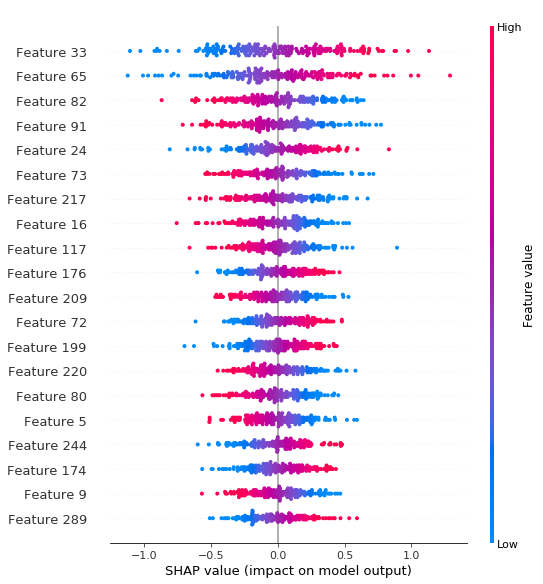

In [34]:
model = LogisticRegression(C= 0.1, solver = 'liblinear', penalty='l2', class_weight='balanced')
sc = StandardScaler()
x_train = sc.fit_transform(train_data)
x_val = sc.transform(val_data)
oof6, score6, predition6 = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)
explainer = shap.LinearExplainer(model, x_train)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

In [35]:
sfs1 = SFS(model, k_features=(10, 15), forward=True, floating=True, scoring='roc_auc', cv= folds)
sfs1 = sfs1.fit(x_train, train_label)

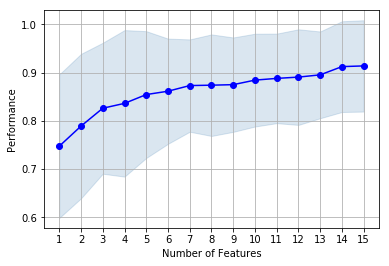

In [36]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

In [37]:
top_feature = [int(i) for i in sfs1.k_feature_names_]
x_train = train_data[:, top_feature]
x_val = val_data[:,top_feature]
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
model = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', class_weight ='balanced')
oof6, score6, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.7849, std: 0.1388.


In [38]:
sc = StandardScaler()
x_train = sc.fit_transform(train_data)
x_val = sc.transform(val_data)

In [40]:
model = LogisticRegression(solver='liblinear', max_iter=100)
params = {'penalty' : ["l2"],
          'C': [0.01, 0.1, 1, 10],
          'class_weight' : ['balanced', None],
          'solver': ['newton-cg', 'lbfgs']}
model = GridSearchCV(model, params, cv=folds, scoring='roc_auc')
model.fit(x_train, train_label)
print("best score ", model.best_score_)
print("best params ", model.best_params_)

best score  0.7550595238095238
best params  {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}


/home/yas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [41]:
model = LogisticRegression(solver='liblinear', C=20, max_iter=10000, penalty='l2')
oof6, score_lr, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.6864, std: 0.1493.


In [42]:
from sklearn.svm import SVC
model_svm = SVC()
grid_params = {'C':[0.01, 0.03, 0.09, 0.5],
               'kernel':['rbf', 'linear', 'poly']}
grid_model = GridSearchCV(model_svm, grid_params, cv=folds, n_jobs=-1)
grid_model.fit(x_train, train_label)
print("best parameters :", grid_model.best_params_)
print("best score :", grid_model.best_score_)
model = SVC(gamma = 'scale', probability =True,**grid_model.best_params_)
_, score_svm, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.6775, std: 0.1470.


In [43]:
from sklearn.gaussian_process import GaussianProcessClassifier
model_gpc = GaussianProcessClassifier()
model = GaussianProcessClassifier()
_, score_gpc, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.5850, std: 0.1536.


In [43]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
grid_params = {'n_estimators': [10, 50, 100, 1000],
                  'max_depth': [None, 3, 5, 15]
                 }
#grid_model = GridSearchCV(model_rf, grid_params, cv=folds, n_jobs=-1)
#grid_model.fit(x_train, train_label)
#print("best parameters :", grid_model.best_params_)
#print("best score :", grid_model.best_score_)
#model = RandomForestClassifier(**grid_model.best_params_)
#_, score_rf, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

In [46]:
from sklearn.ensemble import AdaBoostClassifier
model_abc = AdaBoostClassifier()
grid_params = {'n_estimators':[10, 100],
               'learning_rate':[0.01, 0.3, 10]}
grid_model = GridSearchCV(model_abc, grid_params, cv=folds, n_jobs=-1)
grid_model.fit(x_train, train_label)

print("best parameters :", grid_model.best_params_)
print("best score :", grid_model.best_score_)
model = AdaBoostClassifier(**grid_model.best_params_)
_, score_abc, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.5752, std: 0.1170.


In [47]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

parameter_grid = {'class_weight': [None, 'balanced'],
                  'max_depth': [None, 3, 5, 15]
                 }

grid_search = GridSearchCV(etc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(x_train, train_label)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
model = ExtraTreesClassifier(**grid_search.best_params_)
_, score_etc, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.5557, std: 0.1639.


In [48]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
_, score_gnb, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.6336, std: 0.1427.


In [49]:
from sklearn.linear_model import SGDClassifier
model_sgd = SGDClassifier(eta0=1, loss='log')
grid_params = {'learning_rate':['optimal', 'invscaling'], 
               'class_weight': ['balanced', None],
               'penalty':['l1', 'l2']}
grid_model = GridSearchCV(model_sgd, grid_params, cv=folds, n_jobs=-1)
grid_model.fit(x_train, train_label)
print("best parameters :", grid_model.best_params_)
print("best score :", grid_model.best_score_)
model = SGDClassifier(eta0=1, loss='log', **grid_model.best_params_)
_, score_sgd, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.6600, std: 0.1511.


In [50]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()

grid_params = {'n_neighbors': [2, 3, 20],
                  'weights': ['uniform', 'distance'],
                  'leaf_size': [5, 10, 30]
                 }
grid_model = GridSearchCV(model_knn, grid_params, cv=folds, n_jobs=-1, scoring='roc_auc')

grid_model.fit(x_train, train_label)
print("best parameters :", grid_model.best_params_)
print("best score :", grid_model.best_score_)
model = KNeighborsClassifier(**grid_model.best_params_)
_, score_knn, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.5829, std: 0.1241.


In [51]:
from sklearn.naive_bayes import BernoulliNB
model_bnb = BernoulliNB()
grid_params = {'alpha':[0, 0.1, 1, 10],
               'binarize':[0, 0.1, 1]}
grid_model = GridSearchCV(model_bnb, grid_params, cv=folds, n_jobs=-1)
grid_model.fit(x_train, train_label)
print("best parameters :", grid_model.best_params_)
print("best score :", grid_model.best_score_)
model = BernoulliNB(**grid_model.best_params_)
_, score_bnb, _ = train_model(x_train, train_label, x_val, params=None, model= model, folds=repeatedfolds)

CV mean score: 0.6141, std: 0.1539.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

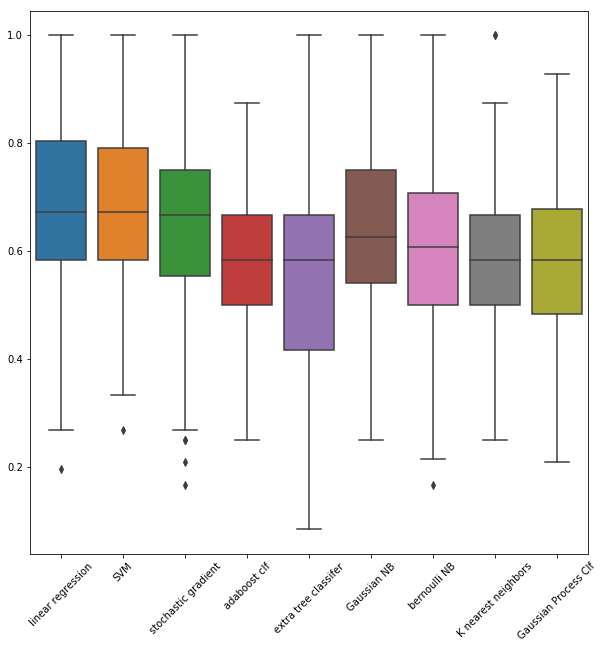

In [53]:
fig = plt.figure(figsize=(10, 10))
box_data = pd.DataFrame({'linear regression': score_lr})
box_data['SVM'] = score_svm
box_data['stochastic gradient'] = score_sgd
box_data['adaboost clf'] = score_abc
box_data['extra tree classifer'] = score_etc
#box_data['Random forest'] = score_rf
box_data['Gaussian NB'] = score_gnb
box_data['bernoulli NB'] = score_bnb
box_data['K nearest neighbors'] = score_knn
box_data['Gaussian Process Clf'] = score_gpc
sns.boxplot(data=box_data)
plt.xticks(rotation=45)

In [54]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
x_train = poly.fit_transform(train_data)
x_val = poly.transform(val_data)

In [55]:
x_train.shape, x_val.shape

((200, 45451), (50, 45451))

In [56]:
model = LogisticRegression(C=0.1, solver= 'liblinear', penalty='l1', class_weight='balanced')
oof, score, pred = train_model(x_train, train_label, x_val, params=None,model=model)

CV mean score: 0.5292, std: 0.1564.


In [58]:
corr = pd.DataFrame(x_train).corrwith(pd.Series(train_label))

In [59]:
scores = []
for i in range(10, 500, 5):
    feature = list(corr.abs().sort_values().tail(i).reset_index()['index'].values)
    train = x_train[:,feature]
    val = x_val[:, feature]
    model = LogisticRegression(C=0.1, solver= 'liblinear', penalty='l1', class_weight='balanced')
    _, score, _ = train_model(train, train_label, val, params=None, model= model)
    scores.append(score)

CV mean score: 0.6119, std: 0.1865.


In [60]:
data = [go.Scatter(x = list(range(10, 500, 5)),
                  y = [np.round(np.mean(i), 4) for i in scores],
                  name = 'CV scores')]
layout = go.Layout(dict(title='Top N polynomial feature',
                       xaxis = dict(title = "number of features"),
                       yaxis = dict(title = "cv score"),))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [67]:
del x_val

In [72]:
xtrain = train_data
xtest = test.drop(['id'], axis = 1)

In [73]:
xtrain = np.hstack((xtrain, xtrain.std(1).reshape(-1, 1)))
xtest['300'] = xtest.std(1)
sc = StandardScaler()
xtrain[:, :300]  = sc.fit_transform(xtrain[:, :300])
xtest[xtest.columns[:-1]]  = sc.transform(xtest[xtest.columns[:-1]])
model = LogisticRegression(C = 0.1, solver = 'liblinear', class_weight='balanced', penalty = 'l1')
oof, score, pred = train_model(xtrain, train_label, xtest, params = None, model= model)

CV mean score: 0.7101, std: 0.1199.


In [74]:
submission = pd.DataFrame({'id':test.id})
submission['target'] = pred
submission.to_csv('submission5.csv', index= False)
create_download_link(filename='submission5.csv')

In [76]:
model = LogisticRegression(C = 0.1, solver = 'liblinear', class_weight='balanced', penalty = 'l1')
oof, score, pred = train_model(xtrain, train_label, xtest, params = None, model= model, folds= repeatedfolds)
submission = pd.DataFrame({'id':test.id})
submission['target'] = pred
submission.to_csv('submission6.csv', index= False)
create_download_link(filename='submission6.csv')

CV mean score: 0.6962, std: 0.1371.


In [77]:
xtest = test.drop('id', axis=1)
xtrain = np.hstack((train_data, train_data.std(1).reshape(-1,1)))
xtest['300'] = xtest.std(1)
sc= StandardScaler()
xtrain[:,:300] = sc.fit_transform(xtrain[:, :300])
xtest.iloc[:,:300] = sc.transform(xtest.iloc[:, :300])

In [78]:
from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(n_neighbors=5)
NN.fit(xtrain)
dist, _ = NN.kneighbors(xtrain)
mean_near = dist.mean(1)
min_near = dist.min(1)
max_near = dist.max(1)
std_near = dist.std(1)

In [79]:
stats = np.hstack((mean_near.reshape(-1, 1), min_near.reshape(-1, 1), max_near.reshape(-1, 1), std_near.reshape(-1, 1)))

In [80]:
stats.shape

(200, 4)

In [81]:
dist2, _ = NN.kneighbors(xtest)
mean_near_test = dist2.mean(1)
min_near_test = dist2.min(1)
max_near_test = dist2.max(1)
std_near_test = dist2.std(1)

In [82]:
stats_test = np.hstack((mean_near_test.reshape(-1, 1), 
                        min_near_test.reshape(-1, 1), 
                        max_near_test.reshape(-1, 1), 
                        std_near_test.reshape(-1, 1)))

In [83]:
xtrain = np.hstack((xtrain, stats))
xtest = np.hstack((xtest, stats_test))

In [84]:
model = LogisticRegression(C = 0.1, solver='liblinear', penalty='l1', class_weight='balanced')
oof, score, pred = train_model(xtrain, train_label, xtest, model= model, params= None)
submission = pd.DataFrame({'id':test.id})
submission['target'] = pred
submission.to_csv('submission7.csv', index= False)
create_download_link(filename='submission7.csv')

CV mean score: 0.6542, std: 0.1217.


In [85]:
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectPercentile
xtrain = train_data
xtest = test.drop('id', axis = 1)
sc = StandardScaler()
xtrain = sc.fit_transform(xtrain)
xtest = sc.transform(xtest)

In [86]:
scores = {'f_classif':[], 'mutual_info_classif':[]}
for i in range(5, 100, 5):
    model = LogisticRegression(C = 0.1, solver='liblinear', penalty='l1', class_weight='balanced')
    select_fclass = SelectPercentile(f_classif, i)
    X_train = select_fclass.fit_transform(xtrain, train_label.astype('int'))
    X_test = select_fclass.transform(xtest)
    _, scr, _ = train_model(X_train, train_label, X_test, model=model, params=None)
    scores['f_classif'].append(np.mean(scr))
for i in range(5, 100, 5):
    model = LogisticRegression(C = 0.1, solver='liblinear', penalty='l1', class_weight='balanced')
    select_fclass = SelectPercentile(mutual_info_classif, i)
    X_train = select_fclass.fit_transform(xtrain, train_label.astype('int'))
    X_test = select_fclass.transform(xtest)
    _, scr, _ = train_model(X_train, train_label, X_test, model=model, params=None)
    scores['mutual_info_classif'].append(np.mean(scr))    

CV mean score: 0.7080, std: 0.1251.


In [87]:
data = [go.Scatter(x=list(range(5, 100, 5)),
                   y = scores['f_classif'],
                   name = 'f_classif'),
       go.Scatter(x = list(range(5, 100, 5)),
                  y = scores['mutual_info_classif'],
                  name = 'mutual_info_classif')]
layout = go.Layout(dict(title='top N feature',
                       xaxis=dict(title='percentile'),
                       yaxis = dict(title='score')))
py.iplot(dict(data=data, layout=layout), filename = 'basic-line')

In [88]:
from sklearn.feature_selection import SelectKBest
scores = {'f_classif':[], 'mutual_info_classif':[]}
for i in range(5, 301, 5):
    skb = SelectKBest(f_classif, i)
    X_train = skb.fit_transform(xtrain, train_label)
    X_test = skb.transform(xtest)
    _, scr, _ = train_model(X_train, train_label, X_test, model = model, params = None)
    scores['f_classif'].append(np.mean(scr))
    skb = SelectKBest(mutual_info_classif, i)
    X_train = skb.fit_transform(xtrain, train_label)
    X_test = skb.transform(xtest)
    _, scr, _ = train_model(X_train, train_label, X_test, model = model, params = None)
    scores['mutual_info_classif'].append(np.mean(scr))

CV mean score: 0.7101, std: 0.1199.


In [89]:
data = [go.Scatter(x = list(range(5, 301, 5)),
                   y = scores['f_classif'],
                   name = 'f_classif'),
       go.Scatter(x = list(range(5, 301, 5)),
                  y = scores['mutual_info_classif'],
                  name = 'mutual_info_classif')]
layout = go.Layout(dict(title= 'top feature using selectkbest',
                        xaxis = dict(title= 'number of features'),
                        yaxis = dict(title ='score')))
py.iplot(dict(data=data, layout=layout))

In [90]:
selector = SelectKBest(mutual_info_classif, k=60)
X_train = selector.fit_transform(xtrain, train_label)
X_test = selector.transform(xtest)
_, score, pred = train_model(X_train, train_label, X_test, model =model, params = None)

CV mean score: 0.7542, std: 0.1277.


In [92]:
submission = pd.DataFrame({'id':test.id})
submission['target'] = pred
submission.to_csv('submission8.csv', index= False)
create_download_link(filename='submission8.csv')

In [93]:
from sklearn.feature_selection import RFE
scores = []
for i in range(5, 301, 5):
    rfe = RFE(model, i)
    X_train = rfe.fit_transform(xtrain, train_label)
    X_test = rfe.transform(xtest)
    _, scr, _ = train_model(X_train, train_label, X_test, model = model, params= None)
    scores.append(np.mean(scr))

CV mean score: 0.7101, std: 0.1199.


In [94]:
data = [go.Scatter(x = list(range(5, 301, 5)),
                   y = scores,
                   name = 'rfe')]
layout= go.Layout(dict(title='top feature using rfe',
                      xaxis = dict(title='number of features'),
                      yaxis = dict(title = 'score')))
py.iplot(dict(data= data, layout=layout))

In [95]:
selector= RFE(model, 15)
X_train = selector.fit_transform(xtrain, train_label)
X_test = selector.transform(xtest)
_, scr, pred = train_model(X_train, train_label, X_test, model= model, params= None)

CV mean score: 0.7708, std: 0.1398.


In [96]:
submission = pd.DataFrame({'id':test.id})
submission['target'] = pred
submission.to_csv('submission9.csv', index= False)
create_download_link(filename='submission9.csv')

In [124]:
xtrain = train_data.copy()
xtest = test.drop('id', axis=1)
model = LogisticRegression(C=0.1, solver='liblinear', class_weight='balanced')
model.fit(xtrain, train_label)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [125]:
feature_weight = eli5.formatters.as_dataframe.explain_weights_df(model)
feature_weight['weight'] = feature_weight['weight'].abs()
feature_weight = feature_weight.sort_values('weight', ascending= False)

In [126]:
feature_weight.head()

,target,feature,weight
0,1.0,x33,0.437711
1,1.0,x65,0.433608
2,1.0,<BIAS>,0.428185
3,1.0,x24,0.319395
300,1.0,x82,0.299113


In [127]:
xtrain = np.hstack((xtrain, xtrain.mean(1).reshape(-1,1)))
xtest['mean'] = xtest.mean(1)
xtrain = np.hstack((xtrain, xtrain.std(1).reshape(-1,1)))
xtest['std'] = xtest.std(1)

In [128]:
xtrain = pd.DataFrame(xtrain, columns=xtest.columns)
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,mean,std
0,0.188651,1.394180,0.719969,-1.603926,1.759982,-0.394620,-2.900234,0.994814,-0.579765,-1.720235,...,-0.409721,-0.595530,-0.885988,-0.781487,-0.451686,-0.330268,0.298779,-0.500114,0.031973,1.004298
1,0.474242,-0.843515,0.002057,2.209561,1.290588,0.436525,1.780788,0.818110,-0.962149,0.032150,...,-2.825270,-1.505804,0.539612,0.880086,-0.177276,0.086629,-1.023908,-0.046981,-0.010725,1.021393
2,-0.438814,-1.421728,0.922730,-0.614709,1.008364,0.289047,0.103365,0.199106,-0.306634,-1.009835,...,-1.149832,0.015434,-0.932255,0.583935,0.620826,1.331052,0.917909,-0.234738,0.055704,0.991229
3,-0.023978,0.205687,-0.072645,-1.183413,0.570328,0.765190,-0.039664,1.647424,0.843610,0.715983,...,-1.197027,-0.203649,-0.380907,0.345451,-0.959295,0.837880,-0.362080,-2.082932,-0.111368,0.973114
4,0.622248,-0.479752,1.122581,-0.116252,-0.113674,-0.950823,-0.835564,0.531916,0.737450,0.143334,...,-0.461207,0.025719,0.571421,0.224254,0.424818,0.031252,-0.437773,0.017003,-0.011011,0.974892


In [122]:
xtest = xtest.values

In [136]:
scores = {'simple':[], 'mean':[], 'std': []}
for i in range(1, 50):
    top_features = [i[1:] for i in feature_weight['feature'] if 'BIAS' not in i][:i]
    X_train = xtrain.loc[:,top_features]
    X_test = xtest.loc[:,top_features]
    _, scr, _ = train_model(X_train.values, train_label, X_test.values, model = model, params=None)
    scores['simple'].append(np.mean(scr))
    
    X_train = xtrain.loc[:,top_features + ['mean']]
    X_test = xtest.loc[:,top_features + ['mean']]
    _, scr, _ = train_model(X_train.values, train_label, X_test.values, model = model, params=None)
    scores['mean'].append(np.mean(scr))
    
    X_train = xtrain.loc[:,top_features + ['std']]
    X_test = xtest.loc[:,top_features + ['std']]
    _, scr, _ = train_model(X_train.values, train_label, X_test.values, model = model, params=None)
    scores['std'].append(np.mean(scr))

CV mean score: 0.8857, std: 0.1146.


In [137]:
data = [go.Scatter(x = list(range(1, 50)),
                   y = scores['simple'],
                   name = 'Simple'),
        go.Scatter(x= list(range(1, 50)),
                   y = scores['mean'],
                   name = 'Mean'),
        go.Scatter(x = list(range(1, 50)),
                   y = scores['std'],
                   name = 'std')]
layout = go.Layout(dict(title='Top Feature with stats',
                       xaxis = dict(title = 'number of features'),
                       yaxis = dict(title = 'score')))
py.iplot(dict(data=data, layout= layout))

In [141]:
scores = {'simple':[], 'mean':[], 'std': []}
for i in range(1, 50, 5):
    top_features = [i[1:] for i in feature_weight['feature'] if 'BIAS' not in i][:i]
    X_train = xtrain[top_features]
    X_test = xtest[top_features]
    _, scr, _ = train_model(X_train.values, train_label, X_test.values, model = model, params=None, folds=repeatedfolds)
    scores['simple'].append(np.mean(scr))
    
    X_train = xtrain[top_features + ['mean']]
    X_test = xtest[top_features + ['mean']]
    _, scr, _ = train_model(X_train.values, train_label, X_test.values, model = model, params=None, folds=repeatedfolds)
    scores['mean'].append(np.mean(scr))
    
    X_train = xtrain[top_features + ['std']]
    X_test = xtest[top_features + ['std']]
    _, scr, _ = train_model(X_train.values, train_label, X_test.values, model = model, params=None, folds=repeatedfolds)
    scores['std'].append(np.mean(scr))

CV mean score: 0.8755, std: 0.1065.


In [143]:
top = 45
top_features = [i[1:] for i in feature_weight['feature'] if 'BIAS' not in i][:top]
X_train = xtrain.loc[:,top_features + ['std']]
X_test = xtest.loc[:,top_features + ['std']]
_, scr, pred = train_model(X_train.values, train_label, X_test.values, model = model, params = None)

CV mean score: 0.8747, std: 0.1050.


In [144]:
submission = pd.DataFrame({'id':test.id})
submission['target'] = pred
submission.to_csv('submission10.csv', index=False)
create_download_link(filename = 'submission10.csv')

In [145]:
top = 15
top_features = [i[1:] for i in feature_weight['feature'] if 'BIAS' not in i][:top]
X_train = xtrain.loc[:,top_features + ['std']]
X_test = xtest.loc[:,top_features + ['std']]
_, scr, pred = train_model(X_train.values, train_label, X_test.values, model = model, params = None)

CV mean score: 0.7964, std: 0.1277.


In [146]:
submission = pd.DataFrame({'id':test.id})
submission['target'] = pred
submission.to_csv('submission10_1.csv', index=False)
create_download_link(filename = 'submission10_1.csv')